## Run veloVAE

In [1]:
import os

os.environ["TF_USE_LEGACY_KERAS"] = "True"
import anndata
import numpy as np
import scvelo as scv
import scanpy as sc
import sys
import torch
import os.path

sys.path.insert(1, "../")
import velovae as vv
from scipy.sparse import csr_matrix
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from torch import nn
import numpy as np
import torch
import pandas as pd
import seaborn as sns

import os
from typing import Literal
import anndata as ad
import scanpy as sc
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

## General setting

In [3]:
model_path = f"checkpoints/"
figure_path = f"figures/"
data_path = f"data/"

sns.reset_defaults()
sns.reset_orig()
scv.settings.set_figure_params("scvelo", dpi_save=400, dpi=80, transparent=True, fontsize=20, color_map="viridis")

sys.path.append("../..")
from paths import DATA_DIR, FIG_DIR

## load dataset

In [4]:
adata = sc.read(DATA_DIR / "cell_cycle" / "cell_cycle_processed.h5ad")

In [5]:
# n_gene = 2000
# vv.preprocess(adata, n_gene)
torch.manual_seed(2022)
np.random.seed(2022)
vae = vv.VAE(adata, tmax=20, dim_z=5, device="cuda:0")

Estimating ODE parameters...


  0%|          | 0/395 [00:00<?, ?it/s]

Detected 333 velocity genes.
Estimating the variance...


  0%|          | 0/395 [00:00<?, ?it/s]

Initialization using the steady-state and dynamical models.
Reinitialize the regular ODE parameters based on estimated global latent time.


  0%|          | 0/395 [00:00<?, ?it/s]

3 clusters detected based on gene co-expression.
(0.43, 0.32566450535716046), (0.57, 0.766859193049105)
(0.52, 0.7043499033815058), (0.48, 0.3233953606122509)
KS-test result: [0. 0. 1.]
Initial induction: 240, repression: 155/395


In [6]:
gene_plot = ["Gng12"]

config = {}
vae.train(adata, config=config, plot=False, gene_plot=gene_plot, embed="umap")
vae.save_model(model_path, "encoder_vae", "decoder_vae")
vae.save_anndata(adata, "vae", data_path, file_name="velovae.h5ad")

Learning Rate based on Data Sparsity: 0.0000
--------------------------- Train a VeloVAE ---------------------------
*********        Creating Training/Validation Datasets        *********
*********                      Finished.                      *********
*********                 Creating optimizers                 *********
*********                      Finished.                      *********
*********                    Start training                   *********
*********                      Stage  1                       *********
Total Number of Iterations Per Epoch: 7, test iteration: 12
*********       Stage 1: Early Stop Triggered at epoch 820.       *********
*********                      Stage  2                       *********
*********             Velocity Refinement Round 1             *********


  0%|          | 0/1146 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.034
Average Set Size: 26
*********     Round 1: Early Stop Triggered at epoch 961.    *********
Change in noise variance: 0.0290
*********             Velocity Refinement Round 2             *********
*********     Round 2: Early Stop Triggered at epoch 970.    *********
Change in noise variance: 0.0007
Change in x0: 0.8261
*********             Velocity Refinement Round 3             *********
*********     Round 3: Early Stop Triggered at epoch 979.    *********
Change in noise variance: 0.0000
Change in x0: 0.5850
*********             Velocity Refinement Round 4             *********
*********     Round 4: Early Stop Triggered at epoch 986.    *********
Change in noise variance: 0.0000
Change in x0: 0.4798
*********             Velocity Refinement Round 5             *********
*********     Round 5: Early Stop Triggered at epoch 1012.    *********
Change in noise variance: 0.0000
Change in x0: 0.3765
*********             Velocity Refinement Round 6   

In [7]:
torch.manual_seed(2022)
np.random.seed(2022)
rate_prior = {"alpha": (0.0, 1.0), "beta": (0.0, 0.5), "gamma": (0.0, 0.5)}
full_vb = vv.VAE(adata, tmax=20, dim_z=5, device="cuda:0", full_vb=True, rate_prior=rate_prior)

Estimating ODE parameters...


  0%|          | 0/395 [00:00<?, ?it/s]

Detected 333 velocity genes.
Estimating the variance...


  0%|          | 0/395 [00:00<?, ?it/s]

Initialization using the steady-state and dynamical models.
Reinitialize the regular ODE parameters based on estimated global latent time.


  0%|          | 0/395 [00:00<?, ?it/s]

3 clusters detected based on gene co-expression.
(0.43, 0.32566450535716046), (0.57, 0.766859193049105)
(0.52, 0.7043499033815058), (0.48, 0.3233953606122509)
KS-test result: [0. 0. 1.]
Initial induction: 240, repression: 155/395


In [8]:
full_vb.train(adata, plot=False, gene_plot=gene_plot, embed="umap")
full_vb.save_model(model_path, "encoder_fullvb", "decoder_fullvb")
full_vb.save_anndata(adata, "fullvb", data_path, file_name="fullvb.h5ad")

Learning Rate based on Data Sparsity: 0.0000
--------------------------- Train a VeloVAE ---------------------------
*********        Creating Training/Validation Datasets        *********
*********                      Finished.                      *********
*********                 Creating optimizers                 *********
*********                      Finished.                      *********
*********                    Start training                   *********
*********                      Stage  1                       *********
Total Number of Iterations Per Epoch: 7, test iteration: 12
*********                      Stage  2                       *********
*********             Velocity Refinement Round 1             *********


  0%|          | 0/1146 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.030
Average Set Size: 24
*********     Round 1: Early Stop Triggered at epoch 1209.    *********
Change in noise variance: 0.0289
*********             Velocity Refinement Round 2             *********
*********     Round 2: Early Stop Triggered at epoch 1218.    *********
Change in noise variance: 0.0006
Change in x0: 0.7788
*********             Velocity Refinement Round 3             *********
*********     Round 3: Early Stop Triggered at epoch 1227.    *********
Change in noise variance: 0.0000
Change in x0: 0.5492
*********             Velocity Refinement Round 4             *********
*********     Round 4: Early Stop Triggered at epoch 1276.    *********
Change in noise variance: 0.0000
Change in x0: 0.4655
*********             Velocity Refinement Round 5             *********
*********     Round 5: Early Stop Triggered at epoch 1318.    *********
Change in noise variance: 0.0000
Change in x0: 0.3225
*********             Velocity Refinement Round 

Computing velocity embedding using scVelo
computing velocity graph (using 1/48 cores)


  0%|          | 0/1146 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'vae_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'vae_velocity_umap', embedded velocity vectors (adata.obsm)
computing velocity graph (using 1/48 cores)


  0%|          | 0/1146 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'vae_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'vae_velocity_umap', embedded velocity vectors (adata.obsm)
Computing velocity embedding using scVelo
computing velocity graph (using 1/48 cores)


  0%|          | 0/1146 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'fullvb_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'fullvb_velocity_umap', embedded velocity vectors (adata.obsm)
computing velocity graph (using 1/48 cores)


  0%|          | 0/1146 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'fullvb_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'fullvb_velocity_umap', embedded velocity vectors (adata.obsm)
---     Computing Peformance Metrics     ---
Dataset Size: 1146 cells, 395 genes
---   Plotting  Results   ---
computing velocity graph (using 1/48 cores)


  0%|          | 0/1146 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'vae_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'vae_velocity_umap', embedded velocity vectors (adata.obsm)


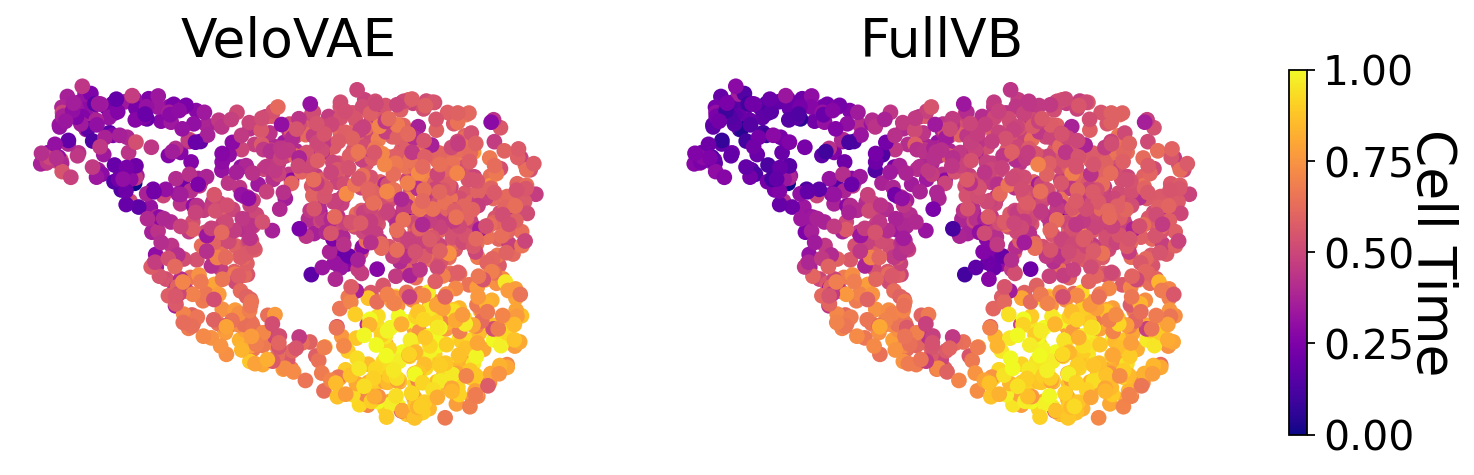

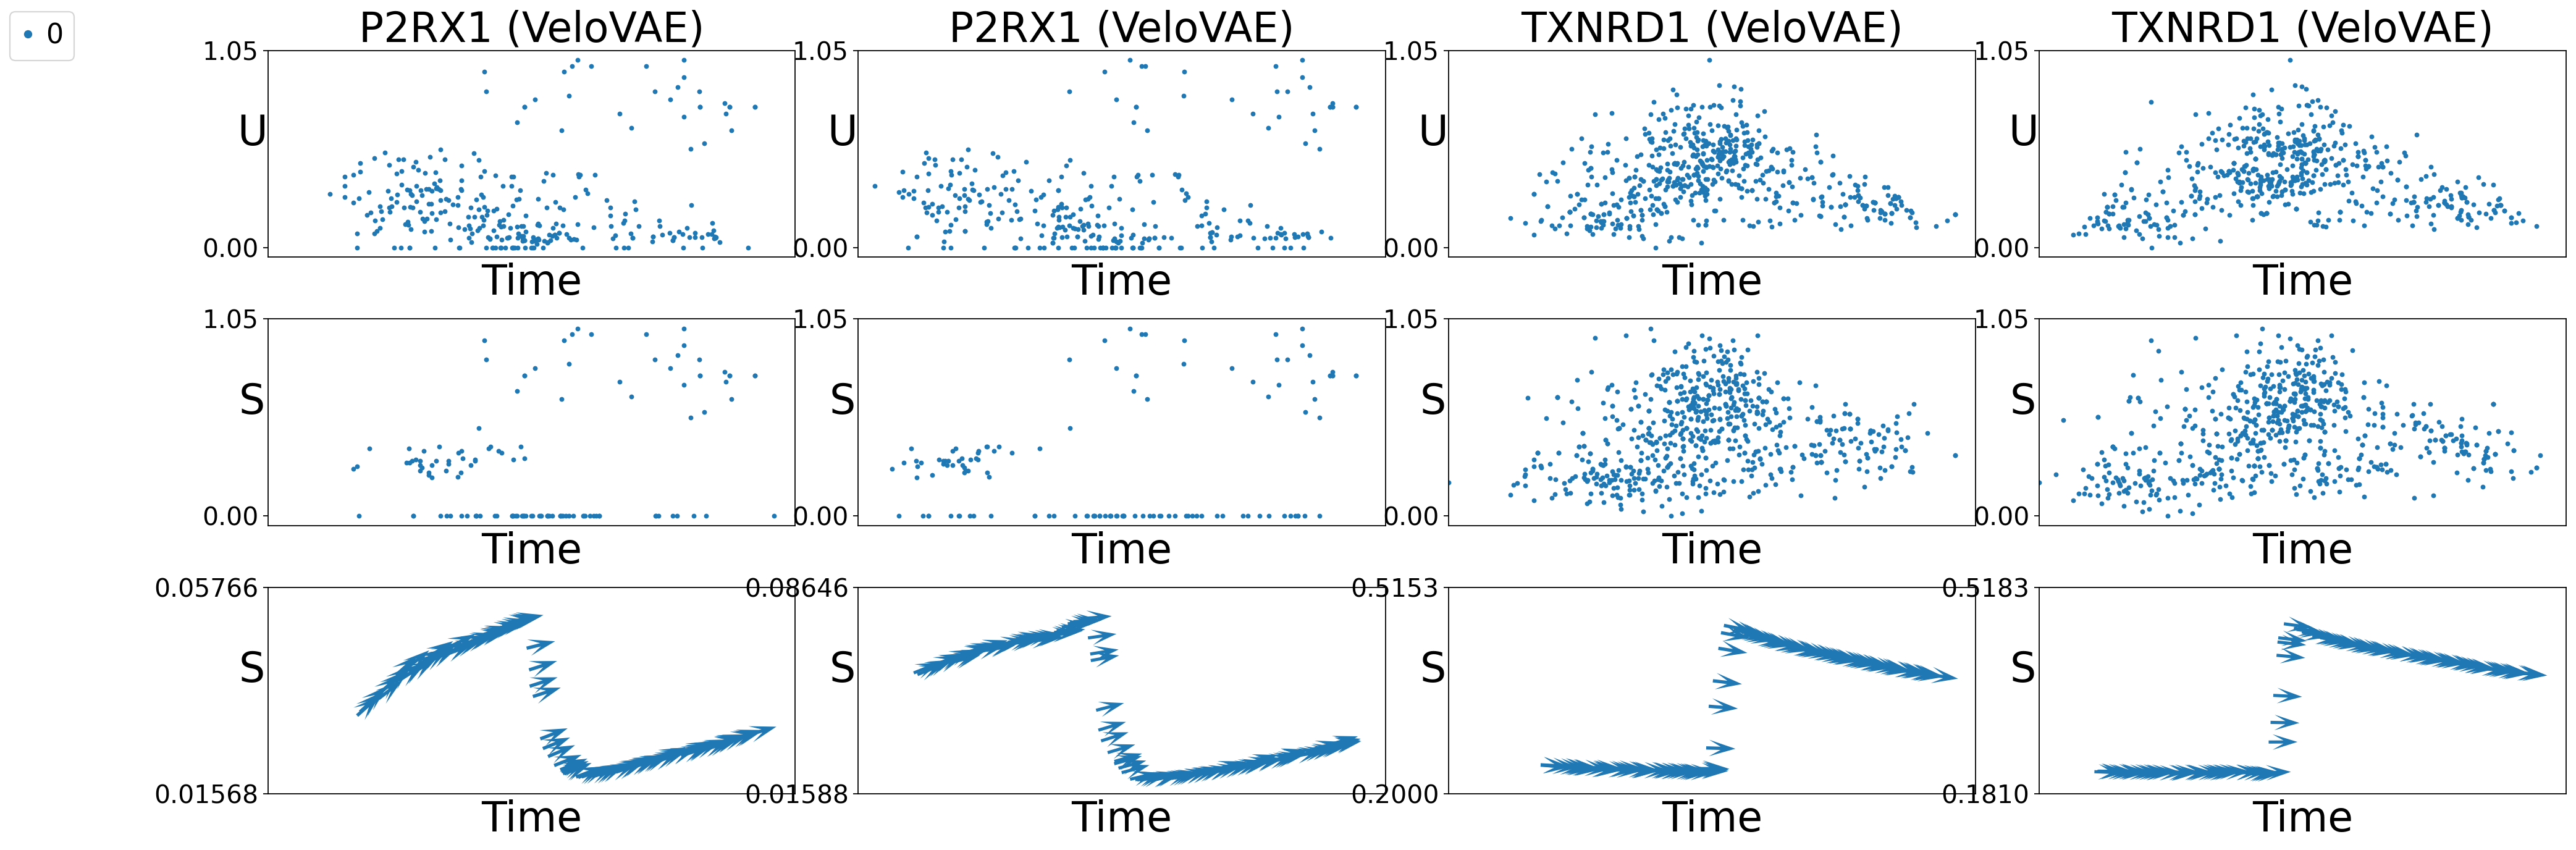

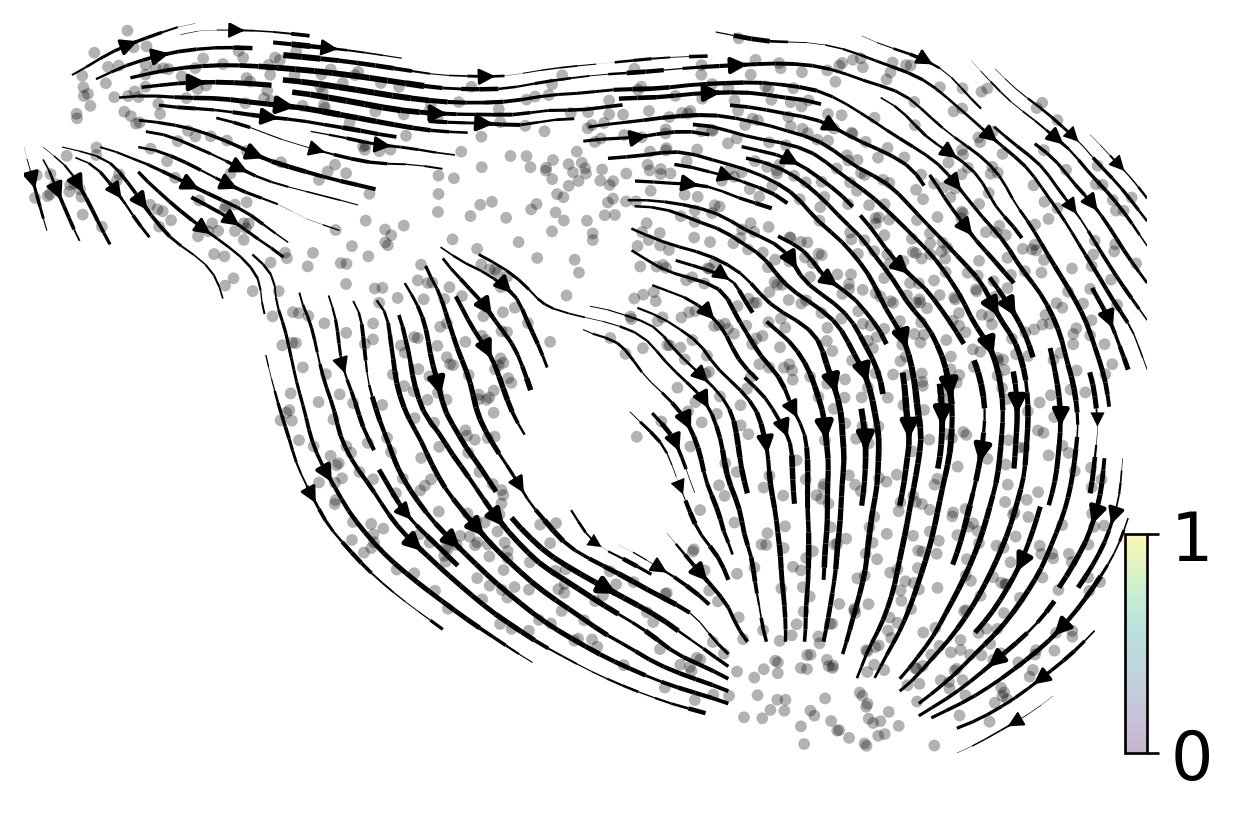

computing velocity graph (using 1/48 cores)


  0%|          | 0/1146 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'fullvb_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'fullvb_velocity_umap', embedded velocity vectors (adata.obsm)


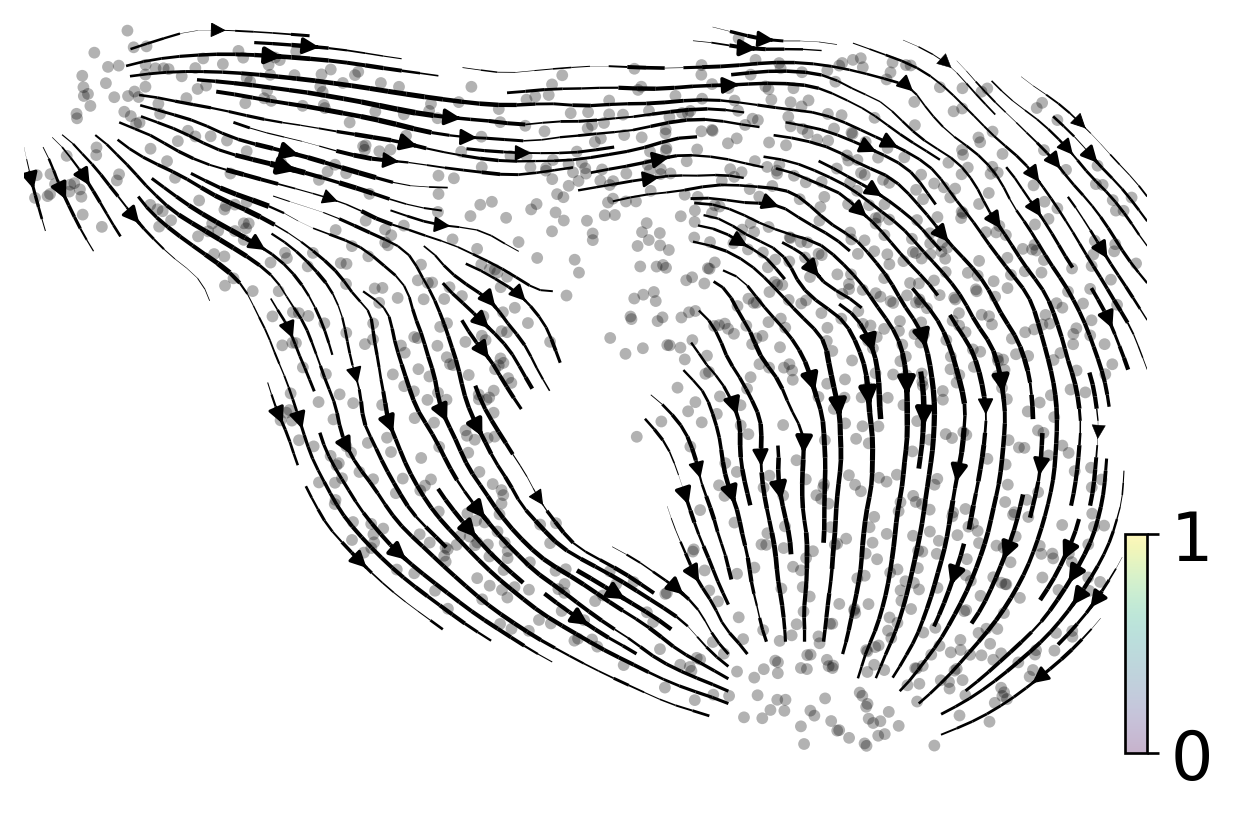

In [9]:
sc.tl.umap(adata)
adata.obs["clusters"] = "0"

methods = ["VeloVAE", "FullVB"]
keys = ["vae", "fullvb"]
grid_size = (1, 2)
res, res_type = vv.post_analysis(
    adata, "continuous", methods, keys, compute_metrics=True, raw_count=False, genes=gene_plot, grid_size=(1, 2)
)

In [10]:
adata

AnnData object with n_obs × n_vars = 1146 × 395
    obs: 'phase', 'fucci_time', 'pseudo_clusters', 'pseudo_clusters_equal_size', 'pseudo_clusters_equal_size_num', 'cell_cycle_rad', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'vae_time', 'vae_std_t', 'vae_t0', 'fullvb_time', 'fullvb_std_t', 'fullvb_t0', 'clusters', 'vae_velocity_consistency', 'vae_velocity_self_transition', 'fullvb_velocity_consistency', 'fullvb_velocity_self_transition'
    var: 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'velocity_gamma', 'velocity_qreg_ratio', 'velocity_r2', 'velocity_genes', 'init_mode', 'w_init', 'vae_alpha', 'vae_beta', 'vae_gamma', 'vae_ton', 'vae_scaling', 'vae_sigma_u', 'vae_sigma_s', 'fullvb_logmu_alpha', 'fullvb_logmu_beta', 'fullvb_logmu_gamma', 'fullvb_logstd_alpha', 'fullvb_logstd_beta', 'fullvb_logstd_gamma', 'fullvb_ton', 'fullvb_scaling', 'fullvb_sigma_u', 'fullvb_sigma_s', 'vae_mse_train', 'vae_mse_test', 'vae_mae_

In [11]:
adata.write(DATA_DIR / "cell_cycle" / "velovae_cycle_filteredgene.h5ad")